# Data Wrangling

## Summary
- data exploration
- data cleaning (nulls)
- feature engineering ()
- creating analytical base table

### Setup Dependencies

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns

In [2]:
df = pd.read_csv('../data/int_online_tx.csv')

### Transaction Level Exploration

In [3]:
df.shape

(35116, 8)

In [4]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


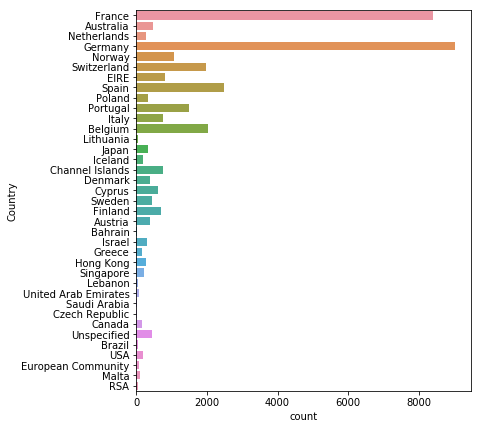

In [5]:
plt.figure(figsize=(6,7))

sns.countplot(y='Country', data=df)

### Transaction-Level Cleaning

In [6]:
# display missing observations for each feature
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [7]:
# drop observations with missing customer ids
df = df[df['CustomerID'].notnull()]

In [8]:
df['CustomerID'] = df.CustomerID.astype(int)

df.CustomerID.head()

0    12583
1    12583
2    12583
3    12583
4    12583
Name: CustomerID, dtype: int64

In [9]:
# convert customerIDs from floats into integers
df['Sales'] = df.Quantity * df.UnitPrice

df['Sales'].head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

### Customer Level Feature Engineering

In [10]:
 # total unique number of transactions for each customer
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({'total_transactions': 'nunique'})

invoice_data.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [11]:
# aggregate product data
product_data = df.groupby('CustomerID').StockCode.agg({'total_products': 'count', 'total_unique_products':'nunique'})

product_data.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


In [12]:
# aggregate sales data by customer
sales_data = df.groupby('CustomerID').Sales.agg({'total_sales': 'sum', 'avg_product_value': 'mean'})

sales_data.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


### Intermediary Levels 

In [13]:
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).Sales.agg({'cart_value':'sum'})

cart_data.reset_index(inplace=True)

cart_data.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91


In [14]:
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg({'avg_cart_value': 'mean','min_cart_value':'min', 'max_cart_value': 'max'})

agg_cart_data.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


### Joining together the ABT (analytical base table)

In [15]:
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


### save abalytical base table

In [16]:
customer_df.to_csv('../data/analytical_base_table.csv')